<a href="https://colab.research.google.com/github/DiMorten/FCN_ConvLSTM_Crop_Recognition_Open_Set/blob/coords5/train_and_evaluate_open_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies

In [1]:
!pip install icecream
#%tensorflow_version 1.x
import os
!pip install kora
from kora import drive
import time
!pip install colorama

ds_path='/content/drive/My Drive/PhD/datasets/cv_data/'

     |████████████████████████████████| 57 kB 2.9 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
git_clone = True

if git_clone == True:
  os.chdir('/content')
  %rm -rf FCN_ConvLSTM_Crop_Recognition_Open_Set
  !git clone --branch coords5 https://github.com/DiMorten/FCN_ConvLSTM_Crop_Recognition_Open_Set.git

Cloning into 'FCN_ConvLSTM_Crop_Recognition_Open_Set'...
remote: Enumerating objects: 2231, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 2231 (delta 11), reused 20 (delta 5), pack-reused 2201
Receiving objects: 100% (2231/2231), 37.51 MiB | 33.00 MiB/s, done.
Resolving deltas: 100% (1477/1477), done.


## Download images into proper folder

In [4]:
!cp -r /content/drive/MyDrive/PhD/datasets/cv_data /content/FCN_ConvLSTM_Crop_Recognition_Open_Set/dataset/dataset/

In [5]:
os.chdir('/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src')
os.getcwd()
os.listdir()

['densnet.py',
 'metrics.py',
 'patch_extractor.py',
 'keras_weighted_categorical_crossentropy.py',
 'modelArchitecture.py',
 'parameters',
 '__init__.py',
 'postprocessing.py',
 'deb.py',
 'obj',
 'analysis',
 'monitor.py',
 'main.py',
 'mosaic.py',
 'densnet_timedistributed.py',
 'mosaic.py.old',
 'train_openset.py',
 'dataset.py',
 'model.py',
 'open_set.py',
 'model_input_mode.py',
 'generator.py',
 'dataSource.py']

In [6]:
from colorama import init
init()
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Conv2DTranspose
# from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping
from tensorflow.keras.optimizers import Adam,Adagrad 
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow.keras as keras

import numpy as np
from sklearn.utils import shuffle
import cv2
import argparse
import tensorflow as tf

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import metrics
import sys
import glob

from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,classification_report
# Local
from densnet import DenseNetFCN
from densnet_timedistributed import DenseNetFCNTimeDistributed

#from metrics import fmeasure,categorical_accuracy
import deb
from keras_weighted_categorical_crossentropy import weighted_categorical_crossentropy, sparse_accuracy_ignoring_last_label, weighted_categorical_crossentropy_ignoring_last_label, categorical_focal_ignoring_last_label, weighted_categorical_focal_ignoring_last_label
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import ConvLSTM2D, UpSampling2D, multiply
from tensorflow.keras.regularizers import l1,l2
import time
import pickle
#from tensorflow.keras_self_attention import SeqSelfAttention
import pdb
import pathlib
from pathlib import Path, PureWindowsPath
from tensorflow.keras.layers import Conv3DTranspose, Conv3D

from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from collections import Counter


#from datagenerator import DataGenerator
from generator import DataGenerator, DataGeneratorWithCoords, DataGeneratorWithCoordsRandom

import matplotlib.pyplot as plt
sys.path.append('../../../dataset/dataset/patches_extract_script/')
from dataSource import DataSource, SARSource, OpticalSource, Dataset, LEM, LEM2, CampoVerde, OpticalSourceWithClouds, Humidity
from model_input_mode import MIMFixed, MIMVarLabel, MIMVarSeqLabel, MIMVarLabel_PaddedSeq, MIMFixedLabelAllLabels, MIMFixed_PaddedSeq
from parameters.parameters_reader import ParamsTrain

from icecream import ic
from monitor import Monitor, MonitorNPY, MonitorGenerator, MonitorNPYAndGenerator
import natsort
from model import NetModel, ModelFit, ModelLoadGeneratorWithCoords
from dataset import Dataset, DatasetWithCoords

from patch_extractor import PatchExtractor
ic.configureOutput(includeContext=False)
np.random.seed(2021)
#tf.random.set_seed(2021)

from main import TrainTest

In [7]:
!nvidia-smi

Mon Aug 23 21:55:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set parameters

Parameters can be modified in /content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src/parameters/parameters_reader.py

In [8]:
from pathlib import Path

paramsTrain = ParamsTrain('parameters/')
paramsTrain.mim = MIMFixed_PaddedSeq()

paramsTrain.getFullIms = True
paramsTrain.coordsExtract = True
paramsTrain.train = True

paramsTrain.train_overlap_percentage = 0
paramsTrain.trainGeneratorRandom = False
paramsTrain.patch_len = 32
paramsTrain.stride = int(paramsTrain.patch_len - paramsTrain.patch_len * paramsTrain.train_overlap_percentage)
paramsTrain.patch_step_train = paramsTrain.stride
paramsTrain.patch_step_test = paramsTrain.patch_len # to do: paramsTrain.getCalculatedParams() does these calculations

paramsTrain.dataset = 'cv'
paramsTrain.seq_date = 'jun'
paramsTrain.path = Path("../../../dataset/dataset/") / (paramsTrain.dataset + "_data")

paramsTrain.test_overlap_percentage = 0

paramsTrain.dataSource = SARSource()
paramsTrain.openSetMethod = None

trainTest = TrainTest(paramsTrain)

patchExtractor = PatchExtractor(paramsTrain, trainTest.ds)	

[@debug] parameters_reader.py:115 in __init__()- self.seq_date: 'mar'


self.known_classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


[@debug] parameters_reader.py:174 in __init__()- self.stride: 32


['save_nonaugmented_train_patches_unknownclasses.json', 'parameters_closedset_groupclasses.json', '__init__.py', 'parameters_reader.py', 'parameters_closedset_groupclasses_lessclass8.json', 'twokkc_save_nonaugmented_train_patches.json', 'parameters_openset_lessclass8.json', 'cv', 'parameters_openset_specifyunknownclasses.json', 'parameters_openset.json', 'twokkc_parameters_openset.json', 'params_batchprocessing.py', '__pycache__', 'no_mode.json', 'allkkc_save_nonaugmented_train_patches.json', 'twokkc_parameters_closedset_groupclasses.json', 'save_nonaugmented_train_patches_lessclass8.json', 'save_nonaugmented_train_patches.json', 'allkkc_parameters_openset.json', 'params_reconstruct.py']
[@debug] self.seq_mode = fixed
[@debug] self.mim = <model_input_mode.MIMFixed_PaddedSeq object at 0x7f0130dd06d0>
[@debug] self.ds = <dataSource.CampoVerde object at 0x7f0130d14690>
20151029
20151110
20151122
20151204
20151216
20160121
20160214
20160309
20160321
20160508
20160520
20160613
dotys_sin_cos

[@debug] patch_extractor.py:17 in __init__()
         self.dataSource: <dataSource.SARSource object at 0x7f0130dd0c50>
[@debug] patch_extractor.py:26 in __init__()
         self.conf['path']/self.label_folder/"/": PosixPath('/')
[@debug] patch_extractor.py:35 in __init__()
         self.conf["in_npy_path"]: PosixPath('../../../dataset/dataset/cv_data/in_sar')
[@debug] patch_extractor.py:43 in __init__()
         self.conf["train"]["mask"]["dir"]: PosixPath('../../../dataset/dataset/cv_data/TrainTestMask.tif')
[@debug] patch_extractor.py:44 in __init__()
         os.getcwd(): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'


## Download or load sequence of images


In [9]:
if paramsTrain.getFullIms == True:
  patchExtractor.getFullIms()	
else:
  patchExtractor.fullImsLoad()


[@debug] patch_extractor.py:90 in getFullIms()
         patch["full_ims"].shape: (12, 8492, 7995, 2)
[@debug] patch_extractor.py:91 in getFullIms()
         self.dataset.im_list: ['20151029_S1',
                                '20151110_S1',
                                '20151122_S1',
                                '20151204_S1',
                                '20151216_S1',
                                '20160121_S1',
                                '20160214_S1',
                                '20160309_S1',
                                '20160321_S1',
                                '20160508_S1',
                                '20160520_S1',
                                '20160613_S1']


0 0
[@debug] conf["in_npy_path"]/(im_names[t_step]+".npy") = ../../../dataset/dataset/cv_data/in_sar/20151029_S1.npy
[@debug] patch["full_ims"].dtype = float16
[@debug] np.average(patch["full_ims"][t_step]) = 0.1871337890625
[@debug] np.max(patch["full_ims"][t_step]) = 1.0
[@debug] np.min(patch["full_ims"][t_step]) = 4.172325134277344e-07
../../../dataset/dataset/cv_data/labels/20151029_S1.tif
[@debug] conf["path"]/(self.dataSource.label_folder+"/"+label_names[t_step]+".tif") = ../../../dataset/dataset/cv_data/labels/20151029_S1.tif
[@debug] np.unique(patch["full_label_ims"][t_step],return_counts=True) = (array([ 0,  1,  2,  6,  7,  8,  9, 10, 11], dtype=int8), array([61778564,    45178,    51808,   131138,   438371,   155189,
        5136068,     1007,   156217]))
1 0
[@debug] conf["in_npy_path"]/(im_names[t_step]+".npy") = ../../../dataset/dataset/cv_data/in_sar/20151110_S1.npy
[@debug] patch["full_ims"].dtype = float16
[@debug] np.average(patch["full_ims"][t_step]) = 0.180419921875


[@debug] dataSource.py:369 in im_load()
         patch["full_ims"].shape: (12, 8492, 7995, 2)
[@debug] dataSource.py:370 in im_load()
         patch["full_label_ims"].shape: (12, 8492, 7995)
[@debug] dataSource.py:371 in im_load()
         patch["full_ims"].dtype: dtype('float16')
[@debug] dataSource.py:372 in im_load()
         patch["full_label_ims"].dtype: dtype('int8')


[@debug] np.unique(patch['full_label_ims'],return_counts=True) = (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int8), array([741342768,  17247080,   7809932,  12457060,    185790,     51702,
         2462898,   5372125,   1862268,  24044169,     12084,   1874604]))
0.0 1.0 0.1702
[@debug] self.dataset.name = cv
[@debug] self.dataset.scaler_name = cv
[@debug] self.dataset.seq_mode = fixed
[@debug] self.dataset.seq_date = jun
[@debug] self.dataset.scaler_load = False
[@debug] im.shape = (12, 8492, 7995, 2)
[@debug] im_flat[mask_flat==1,:].shape = (38664648, 2)
0.0001407 1.0 0.0779
[@debug] im_norm.shape = (12, 8492, 7995, 2)
FINISHED NORMALIZING, RESULT:
-1.432 51.53 3.117
[@debug] im.shape = (12, 8492, 7995)
[@debug] mask_train.shape = (8492, 7995)
[@debug] im.dtype = uint8
[@debug] mask_train.dtype = uint8
[@debug] im_train.shape = (12, 8492, 7995)
Train masked unique/count [ 0  1  2  3  4  5  6  7  8  9 10 11] [776057832   9399025   4170646   6930141    103494     346

[@debug] patch_extractor.py:127 in getFullIms()
         self.paramsTrain.path / 'full_ims/full_ims_test.npy': PosixPath('../../../dataset/dataset/cv_data/full_ims/full_ims_test.npy')


## Extract coords of image patches

In [10]:

if paramsTrain.coordsExtract == True:
  patchExtractor.extract()

del patchExtractor



STARTED PATCH EXTRACTION
[@debug] gridx.shape = (250,)
[@debug] gridy.shape = (266,)


[@debug] patch_extractor.py:205 in extract()
         coords_train.shape: (4983, 2)
         coords_test.shape: (4626, 2)
[@debug] patch_extractor.py:206 in extract()
         coords_train.dtype: dtype('int64')
[@debug] patch_extractor.py:207 in extract()
         coords_train[0]: array([7568,  656])


## Train


Initializing object...
12 2
[@debug] self.channel_n = 2


[@debug] dataset.py:96 in __init__()- self.class_n: 10


[@debug] self.t_len = 12
Initializing Dataset instance


[@debug] main.py:119 in setData()- self.data.class_n: 10
[@debug] main.py:147 in preprocess()
         self.model_name: '../results/convlstm_results/model/lm/model_best_UUnetConvLSTM_mar_lm_nomode.h5'
[@debug] dataset.py:186 in create_load()
         os.path.dirname(os.path.abspath(__file__)): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'
[@debug] dataset.py:187 in create_load()
         os.getcwd(): '/content/FCN_ConvLSTM_Crop_Recognition_Open_Set/networks/convlstm_networks/train_src'
[@debug] dataset.py:191 in create_load()
         self.patches['train']['coords'].shape: (4983, 2)
[@debug] dataset.py:284 in labelPreprocess()
         np.unique(self.full_label_train, return_counts=True): (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8),
                                                                array([64671486,   710232,  1374508,    31550,   136800,   212701,
                                                                   

[@debug] np.unique(self.full_label_train, return_counts=True) = (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8), array([64671486,   710232,  1374508,    31550,   136800,   212701,
          71804,   617076,      699,    66684]))


[@debug] dataset.py:343 in labelPreprocess()
         self.labels2new_labels: {0: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8, 11: 9}
         self.new_labels2labels: {0: 0, 1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11}


Transforming labels2new_labels...
Transformed labels2new_labels. Moving bcknd to last...
[@debug] dict_filename = results/label_translations/new_labels2labels_cv_20160613_S1.pkl
[@debug] self.new_labels2labels = {0: 0, 1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11}


[@debug] dataset.py:364 in labelPreprocess()
         np.unique(self.full_label_train, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                                array([64671486,   710232,  1374508,    31550,   136800,   212701,
                                                                         71804,   617076,      699,    66684]))


Moved bcknd to last


[@debug] dataset.py:373 in labelPreprocess()
         np.unique(self.full_label_train, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                                array([  710232,  1374508,    31550,   136800,   212701,    71804,
                                                                        617076,      699,    66684, 64671486]))
[@debug] dataset.py:374 in labelPreprocess()
         np.unique(self.full_label_test, return_counts=True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                               array([  730790,  1199149,    25986,    88785,   312353,    83385,
                                                                       362633,      308,    89533, 65000618]))
[@debug] dataset.py:377 in labelPreprocess()- self.class_n: 10
[@debug] dataset.py:215 in create_load()
         self.patches['train']['label'].shape: (4983, 32, 32)
[@debug] dataset.py:216 in cr

=== SELECT VALIDATION SET FROM TRAIN SET


[@debug] main.py:160 in preprocess()- self.paramsTrain.val_set: True


[@debug] self.paramsTrain.val_set_mode = random


[@debug] dataset.py:402 in val_set_get()
         self.patches['train']['n']: 4983
         self.patches['val']['n']: 747
[@debug] dataset.py:403 in val_set_get()
         self.patches['train']['coords'].shape: (4983, 2)
[@debug] dataset.py:412 in val_set_get()
         self.patches['train']['coords'].shape: (4236, 2)
[@debug] dataset.py:413 in val_set_get()
         self.patches['val']['coords'].shape: (747, 2)
[@debug] main.py:164 in preprocess()
         self.data.patches['val']['coords'].shape: (747, 2)


=== AUGMENTING TRAINING DATA
[@debug] label_type = Nto1
Before balancing:
data.semantic_balance


[@debug] dataset.py:439 in semantic_balance()
         balance["coords"].shape: (6300, 2)
[@debug] dataset.py:443 in semantic_balance()
         np.unique(self.full_label_train, return_counts = True): (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
                                                                  array([  710232,  1374508,    31550,   136800,   212701,    71804,
                                                                          617076,      699,    66684, 64671486]))
[@debug] dataset.py:449 in semantic_balance()
         coords_classes.shape: (4236, 10)
[@debug] dataset.py:451 in semantic_balance()
         unique_train: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)
[@debug] dataset.py:453 in semantic_balance()- bcknd_idx: 9
[@debug] dataset.py:455 in semantic_balance()- psize: 32
[@debug] dataset.py:468 in semantic_balance()
         patch_count: array([1055., 1820.,   55.,  196.,  352.,  125.,  882.,    6.,  120.,
                                0.])

[@debug] clss = 0


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 1820.0
[@debug] dataset.py:478 in semantic_balance()- clss: 1
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([2416, 1820]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (1820, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 1


[@debug] dataset.py:474 in semantic_balance()- patch_count[clss]: 55.0
[@debug] dataset.py:478 in semantic_balance()- clss: 2
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4181,   55]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (55, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 2


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 196.0
[@debug] dataset.py:478 in semantic_balance()- clss: 3
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4040,  196]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (196, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 3


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 352.0
[@debug] dataset.py:478 in semantic_balance()- clss: 4
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([3884,  352]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (352, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 4


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 125.0
[@debug] dataset.py:478 in semantic_balance()- clss: 5
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4111,  125]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (125, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 5


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 882.0
[@debug] dataset.py:478 in semantic_balance()- clss: 6
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([3354,  882]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (882, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 6


[@debug] dataset.py:474 in semantic_balance()- patch_count[clss]: 6.0
[@debug] dataset.py:478 in semantic_balance()- clss: 7
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4230,    6]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (6, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 7


[@debug] dataset.py:474 in semantic_balance()
         patch_count[clss]: 120.0
[@debug] dataset.py:478 in semantic_balance()- clss: 8
[@debug] dataset.py:481 in semantic_balance()
         idxs.shape: (4236,)
         idxs.dtype: dtype('bool')
[@debug] dataset.py:482 in semantic_balance()
         np.unique(idxs, return_counts = True): (array([False,  True]), array([4116,  120]))
[@debug] dataset.py:487 in semantic_balance()
         balance["class_coords"].shape: (120, 2)
[@debug] dataset.py:488 in semantic_balance()- samples_per_class: 700


[@debug] clss = 8
Balanced train unique (coords):
[@debug] self.patches['train']['coords'].shape = (6300, 2)
[@debug] self.data.patches['train']['coords'].shape = (6300, 2)
Initializing object...
12 2
[@debug] self.channel_n = 2
[@debug] self.t_len = 12
Initializing Model instance
[@debug] self.mp = {'dense': {'recurrent_filters': 128, 'nb_dense_block': 2, 'growth_rate': 64, 'nb_layers_per_block': 1}, 'unet': {'recurrent_filters': 128, 'filter_size': 16}, 'atrous': {'recurrent_filters': 128, 'filter_size': 16, 'dilation_rate_mode': 'auto', 'dilation_rates': [1, 2, 4, 8]}}
[@debug] self.stop_epoch = 400


[@debug] main.py:133 in setModel()
         self.model.name: PosixPath('../results/convlstm_results/model/lm/../results/convlstm_results/model/lm/model_best_UUnetConvLSTM_mar_lm_nomode.h5')
[@debug] main.py:135 in setModel()- self.model.class_n: 9
[@debug] main.py:136 in setModel()- self.data.class_n: 10


[@debug] self.data.class_n = 10
[@debug] self.t_len = 12
[@debug] self.model_t_len = 12
[@debug] K.int_shape(x) = (None, 12, 8, 8, 64)
[@debug] K.int_shape(res2) = (None, 8, 8, 64)
[@debug] K.int_shape(p3) = (None, 8, 8, 64)
[@debug] K.int_shape(d3) = (None, 8, 8, 64)
[@debug] K.int_shape(x) = (None, 12, 16, 16, 32)
[@debug] K.int_shape(res2) = (None, 16, 16, 32)
[@debug] K.int_shape(p2) = (None, 16, 16, 32)
[@debug] K.int_shape(d2) = (None, 16, 16, 32)
[@debug] K.int_shape(x) = (None, 12, 32, 32, 16)
[@debug] K.int_shape(res2) = (None, 32, 32, 16)
[@debug] K.int_shape(p1) = (None, 32, 32, 16)
[@debug] K.int_shape(d1) = (None, 32, 32, 16)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12, 32, 32,  0                                            
_________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
[@debug] model.py:243 in train()
         data.patches['train']['coords'].shape: (6300, 2)
[@debug] model.py:248 in train()- data.t_len: 12
[@debug] model.py:249 in train()
         data.full_ims_train.shape: (12, 8492, 7995, 2)
[@debug] model.py:250 in train()- self.model_t_len: 12
[@debug] dataset.py:386 in addPaddingToInput()
         im.shape: (12, 8492, 7995, 2)
[@debug] model.py:256 in train()
         data.full_ims_train.shape: (12, 8492, 7995, 2)
[@debug] model.py:259 in train()
         self.name: PosixPath('../results/convlstm_results/model/lm/../results/convlstm_results/model/lm/model_best_UUnetConvLSTM_mar_lm_nomode.h5')
[@debug] model.py:314 in applyFitMethod()- self.class_n: 9
[@debug] model.py:333 in applyFitMethod()
         data.patches['train']['coord

Epoch 1/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.1076

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 83s 149ms/step - loss: 0.2301 - accuracy: 0.1076 - val_loss: 0.1941 - val_accuracy: 0.2496


[@debug] generator.py:192 in __len__()- n_batches: 46
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 — val_f1: [60.02 77.99  3.3  28.71 27.76 66.42 55.85  0.   22.79]
 — val_precision: [56.1  92.6   2.19 20.19 52.49 59.86 51.3   0.   18.73]
 — val_recall: [64.54 67.36  6.73 49.67 18.87 74.61 61.29  0.   29.11]
 — mean_f1: 38.093333333333334
oa 60.26
Found best weights at epoch 1
Epoch 2/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.1409

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 142ms/step - loss: 0.1609 - accuracy: 0.1409 - val_loss: 0.1309 - val_accuracy: 0.1688


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [71.38 91.3  36.3  49.38 66.82 79.53 65.91 34.34]
 — val_precision: [79.89 90.85 24.92 38.05 69.53 72.28 69.74 29.88]
 — val_recall: [64.51 91.75 66.77 70.32 64.31 88.41 62.48 40.36]
 — mean_f1: 54.99555555555556
oa 76.29
Found best weights at epoch 2
Epoch 3/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.1347

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 141ms/step - loss: 0.1277 - accuracy: 0.1347 - val_loss: 0.1166 - val_accuracy: 0.1542


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [73.57 92.64 51.76 66.34 70.02 75.23 69.19 35.79]
 — val_precision: [85.35 92.24 35.92 54.13 76.83 62.77 72.22 25.32]
 — val_recall: [64.65 93.04 92.59 85.68 64.33 93.88 66.4  61.05]
 — mean_f1: 59.39333333333333
oa 78.97
Found best weights at epoch 3
Epoch 4/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.1360

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 141ms/step - loss: 0.1045 - accuracy: 0.1360 - val_loss: 0.0980 - val_accuracy: 0.1647


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [74.94 93.31 55.39 70.28 79.16 84.42 74.1  54.55]
 — val_precision: [84.57 92.63 38.62 58.86 83.33 75.25 76.45 42.54]
 — val_recall: [67.28 94.   97.89 87.2  75.39 96.14 71.9  76.02]
 — mean_f1: 65.12777777777778
oa 82.21
Found best weights at epoch 4
Epoch 5/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.1382

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 141ms/step - loss: 0.0891 - accuracy: 0.1382 - val_loss: 0.0918 - val_accuracy: 0.1618


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [76.13 93.44 59.4  71.93 80.38 82.55 74.38  0.   59.71]
 — val_precision: [86.54 92.21 42.44 58.47 86.65 71.87 77.74  0.   46.09]
 — val_recall: [67.96 94.71 98.95 93.46 74.95 96.94 71.3   0.   84.74]
 — mean_f1: 66.43555555555557
oa 82.93
Found best weights at epoch 5
Epoch 6/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.1398

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 141ms/step - loss: 0.0783 - accuracy: 0.1398 - val_loss: 0.0792 - val_accuracy: 0.1700


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [78.97 94.28 75.91 73.9  81.8  83.54 78.3   0.   65.22]
 — val_precision: [87.45 93.51 61.55 61.39 88.19 73.24 78.58  0.   53.68]
 — val_recall: [71.99 95.06 99.   92.8  76.27 97.2  78.02  0.   83.09]
 — mean_f1: 70.21333333333334
oa 85.27
Found best weights at epoch 6
Epoch 7/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.1405

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 140ms/step - loss: 0.0696 - accuracy: 0.1405 - val_loss: 0.0709 - val_accuracy: 0.1857


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [81.89 94.72 78.9  76.04 82.86 88.15 81.02  0.   67.72]
 — val_precision: [87.78 93.39 71.29 63.52 87.61 80.55 83.22  0.   58.23]
 — val_recall: [76.75 96.08 88.33 94.7  78.6  97.32 78.92  0.   80.9 ]
 — mean_f1: 72.36666666666666
oa 87.0
Found best weights at epoch 7
Epoch 8/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0625 - accuracy: 0.1418

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 140ms/step - loss: 0.0625 - accuracy: 0.1418 - val_loss: 0.0642 - val_accuracy: 0.1930


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [83.9  96.09 68.32 81.82 85.62 91.67 84.5   0.   75.  ]
 — val_precision: [88.78 96.3  68.68 71.51 88.86 86.28 82.14  0.   68.19]
 — val_recall: [79.53 95.88 67.96 95.62 82.61 97.78 87.01  0.   83.31]
 — mean_f1: 74.10222222222222
oa 89.14
Found best weights at epoch 8
Epoch 9/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.1425

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 141ms/step - loss: 0.0566 - accuracy: 0.1425 - val_loss: 0.0624 - val_accuracy: 0.1895


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [84.35 95.92 79.13 81.62 87.36 92.41 84.33  0.   80.51]
 — val_precision: [89.87 96.6  77.38 71.38 87.38 87.58 81.    0.   79.38]
 — val_recall: [79.47 95.24 80.96 95.28 87.34 97.81 87.95  0.   81.68]
 — mean_f1: 76.1811111111111
oa 89.48
Found best weights at epoch 9
Epoch 10/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.1441

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 140ms/step - loss: 0.0518 - accuracy: 0.1441 - val_loss: 0.0575 - val_accuracy: 0.2049


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [88.07 96.52 74.75 81.67 90.17 92.45 88.83  0.   82.26]
 — val_precision: [89.99 97.07 76.18 70.48 91.73 87.31 89.    0.   79.41]
 — val_recall: [86.23 95.97 73.37 97.07 88.67 98.24 88.67  0.   85.33]
 — mean_f1: 77.19111111111111
oa 91.56
Found best weights at epoch 10
Epoch 11/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.1449

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 140ms/step - loss: 0.0478 - accuracy: 0.1449 - val_loss: 0.0557 - val_accuracy: 0.2157


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [88.71 96.58 84.12 81.46 89.6  90.96 88.58  0.   82.01]
 — val_precision: [88.77 97.45 75.31 70.11 91.23 85.06 91.    0.   83.17]
 — val_recall: [88.64 95.72 95.27 97.19 88.03 97.75 86.29  0.   80.88]
 — mean_f1: 78.00222222222222
oa 91.69
Found best weights at epoch 11
Epoch 12/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.1470

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 140ms/step - loss: 0.0437 - accuracy: 0.1470 - val_loss: 0.0522 - val_accuracy: 0.2069


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [89.24 96.84 88.76 82.49 90.85 92.93 90.17  0.   82.14]
 — val_precision: [91.05 97.23 80.77 71.72 90.82 88.98 91.4   0.   83.7 ]
 — val_recall: [87.51 96.44 98.51 97.05 90.88 97.26 88.97  0.   80.63]
 — mean_f1: 79.26888888888888
oa 92.47
Found best weights at epoch 12
Epoch 13/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.1490

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 140ms/step - loss: 0.0410 - accuracy: 0.1490 - val_loss: 0.0508 - val_accuracy: 0.1961


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [89.45 97.37 85.68 85.28 88.52 89.97 90.71  0.   79.45]
 — val_precision: [92.07 97.53 76.88 76.08 88.48 83.29 91.77  0.   77.89]
 — val_recall: [86.98 97.21 96.75 97.02 88.56 97.82 89.68  0.   81.08]
 — mean_f1: 78.49222222222222
oa 92.65
Epoch 14/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.1489

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 140ms/step - loss: 0.0385 - accuracy: 0.1489 - val_loss: 0.0502 - val_accuracy: 0.2186


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [90.49 97.41 80.87 84.51 89.62 94.   91.    0.   81.72]
 — val_precision: [89.58 98.53 72.31 74.77 88.68 91.   94.39  0.   80.23]
 — val_recall: [91.43 96.32 91.73 97.17 90.57 97.2  87.85  0.   83.27]
 — mean_f1: 78.84666666666666
oa 93.02
Epoch 15/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0366 - accuracy: 0.1519

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 139ms/step - loss: 0.0366 - accuracy: 0.1519 - val_loss: 0.0480 - val_accuracy: 0.2104


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [90.92 97.56 86.29 83.75 90.08 92.58 91.96  0.   85.32]
 — val_precision: [91.41 98.07 78.45 73.7  91.18 87.3  94.21  0.   85.07]
 — val_recall: [90.43 97.06 95.86 96.99 89.01 98.54 89.81  0.   85.57]
 — mean_f1: 79.8288888888889
oa 93.49
Found best weights at epoch 15
Epoch 16/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.1505

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 140ms/step - loss: 0.0346 - accuracy: 0.1505 - val_loss: 0.0459 - val_accuracy: 0.2135


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [90.69 97.94 91.55 83.97 91.24 95.44 91.88  0.   87.61]
 — val_precision: [91.13 98.53 84.8  73.92 90.43 93.7  93.67  0.   91.82]
 — val_recall: [90.25 97.37 99.46 97.19 92.07 97.25 90.16  0.   83.77]
 — mean_f1: 81.14666666666668
oa 93.86
Found best weights at epoch 16
Epoch 17/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.1503

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 139ms/step - loss: 0.0328 - accuracy: 0.1503 - val_loss: 0.0450 - val_accuracy: 0.2135


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.12 97.49 84.52 86.21 91.81 93.53 92.04  0.   88.61]
 — val_precision: [91.42 98.27 78.45 77.66 92.12 89.63 94.47  0.   88.11]
 — val_recall: [92.82 96.73 91.61 96.88 91.5  97.79 89.74  0.   89.12]
 — mean_f1: 80.70333333333333
oa 94.02
Epoch 18/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.1525

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 140ms/step - loss: 0.0318 - accuracy: 0.1525 - val_loss: 0.0448 - val_accuracy: 0.2091


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [91.12 97.74 76.52 86.68 91.87 96.41 92.51  0.   85.13]
 — val_precision: [91.21 98.3  62.17 78.6  92.33 95.03 95.38  0.   84.63]
 — val_recall: [91.03 97.19 99.48 96.61 91.42 97.84 89.8   0.   85.64]
 — mean_f1: 79.77555555555556
oa 93.86
Epoch 19/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0323 - accuracy: 0.1502

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 140ms/step - loss: 0.0323 - accuracy: 0.1502 - val_loss: 0.0454 - val_accuracy: 0.2026


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [88.65 97.32 90.58 86.31 91.07 97.24 89.54  0.   84.44]
 — val_precision: [90.73 96.82 83.29 79.27 90.05 97.17 90.96  0.   85.96]
 — val_recall: [86.67 97.83 99.27 94.72 92.11 97.31 88.17  0.   82.97]
 — mean_f1: 80.57222222222224
oa 92.8
Epoch 20/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.1522

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 140ms/step - loss: 0.0306 - accuracy: 0.1522 - val_loss: 0.0408 - val_accuracy: 0.2172


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [91.66 98.1  88.84 83.56 92.38 97.4  92.64  0.   85.78]
 — val_precision: [91.83 98.79 87.69 73.36 92.63 96.42 94.2   0.   84.08]
 — val_recall: [91.5  97.41 90.01 97.06 92.13 98.41 91.13  0.   87.54]
 — mean_f1: 81.1511111111111
oa 94.3
Found best weights at epoch 20
Epoch 21/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.1535

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 141ms/step - loss: 0.0281 - accuracy: 0.1535 - val_loss: 0.0402 - val_accuracy: 0.2192


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.09 98.   93.3  84.84 92.44 96.57 92.7   0.   88.07]
 — val_precision: [91.91 98.42 87.78 75.47 94.57 95.31 94.85  0.   84.42]
 — val_recall: [92.27 97.58 99.56 96.87 90.4  97.86 90.64  0.   92.05]
 — mean_f1: 82.00111111111111
oa 94.52
Found best weights at epoch 21
Epoch 22/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.1546

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 141ms/step - loss: 0.0270 - accuracy: 0.1546 - val_loss: 0.0393 - val_accuracy: 0.2191


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.56 97.97 94.72 87.28 90.97 96.66 93.29  0.   83.08]
 — val_precision: [91.75 98.5  90.45 78.93 92.05 95.35 95.46  0.   82.89]
 — val_recall: [93.38 97.45 99.41 97.6  89.92 98.   91.21  0.   83.27]
 — mean_f1: 81.83666666666667
oa 94.65
Epoch 23/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.1536

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 140ms/step - loss: 0.0258 - accuracy: 0.1536 - val_loss: 0.0377 - val_accuracy: 0.2153


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.6  98.34 95.03 87.03 91.16 98.02 93.14  0.   81.36]
 — val_precision: [93.11 98.81 90.69 78.82 90.76 97.74 93.84  0.   84.18]
 — val_recall: [92.08 97.86 99.81 97.14 91.57 98.29 92.45  0.   78.72]
 — mean_f1: 81.85333333333332
oa 94.8
Epoch 24/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.1518

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 140ms/step - loss: 0.0252 - accuracy: 0.1518 - val_loss: 0.0375 - val_accuracy: 0.2153


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.48 97.87 96.6  86.61 91.85 96.85 92.66  0.   81.2 ]
 — val_precision: [92.85 98.82 93.93 78.17 91.98 95.87 92.59  0.   81.4 ]
 — val_recall: [92.1  96.95 99.43 97.11 91.73 97.86 92.72  0.   81.  ]
 — mean_f1: 81.79111111111112
oa 94.5
Epoch 25/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.1542

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 141ms/step - loss: 0.0244 - accuracy: 0.1542 - val_loss: 0.0384 - val_accuracy: 0.2367


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [91.64 97.06 94.73 88.32 92.52 98.26 92.29  0.   87.38]
 — val_precision: [88.66 98.97 90.54 80.92 93.17 99.25 93.89  0.   86.85]
 — val_recall: [94.83 95.21 99.32 97.2  91.87 97.28 90.74  0.   87.91]
 — mean_f1: 82.46666666666665
oa 94.1
Found best weights at epoch 25
Epoch 26/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.1554

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 141ms/step - loss: 0.0244 - accuracy: 0.1554 - val_loss: 0.0352 - val_accuracy: 0.2105


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.76 98.14 96.31 88.21 92.5  97.93 93.43  0.   86.58]
 — val_precision: [93.61 98.66 93.54 80.39 93.35 98.55 93.27  0.   85.24]
 — val_recall: [91.92 97.63 99.24 97.71 91.66 97.31 93.59  0.   87.96]
 — mean_f1: 82.87333333333333
oa 95.05
Found best weights at epoch 26
Epoch 27/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0229 - accuracy: 0.1533

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 141ms/step - loss: 0.0229 - accuracy: 0.1533 - val_loss: 0.0347 - val_accuracy: 0.2210


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.46 98.23 92.22 88.57 91.49 96.65 94.03  0.   83.68]
 — val_precision: [92.75 98.44 88.99 81.32 94.11 96.11 96.66  0.   76.56]
 — val_recall: [94.19 98.02 95.69 97.25 89.01 97.19 91.53  0.   92.26]
 — mean_f1: 82.03666666666666
oa 95.16
Epoch 28/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.1520

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 141ms/step - loss: 0.0220 - accuracy: 0.1520 - val_loss: 0.0344 - val_accuracy: 0.2301


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.24 98.44 96.46 88.87 92.28 97.37 93.06  0.   85.54]
 — val_precision: [91.63 98.69 93.51 81.81 93.2  96.69 96.26  0.   86.4 ]
 — val_recall: [94.9  98.19 99.61 97.27 91.38 98.06 90.07  0.   84.7 ]
 — mean_f1: 82.80666666666667
oa 95.22
Epoch 29/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.1546

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 141ms/step - loss: 0.0208 - accuracy: 0.1546 - val_loss: 0.0334 - val_accuracy: 0.2236


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.77 98.03 95.78 87.63 91.68 94.83 93.95  0.   85.81]
 — val_precision: [92.05 98.09 93.08 80.09 94.   92.08 96.58  0.   84.07]
 — val_recall: [93.49 97.97 98.65 96.74 89.47 97.74 91.46  0.   87.62]
 — mean_f1: 82.27555555555556
oa 94.95
Epoch 30/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.1523

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 55s 141ms/step - loss: 0.0254 - accuracy: 0.1523 - val_loss: 0.0338 - val_accuracy: 0.2071


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [91.96 98.28 91.3  86.78 92.8  96.74 92.37  0.   88.83]
 — val_precision: [93.36 98.49 84.98 78.6  93.45 96.12 92.78  0.   88.51]
 — val_recall: [90.61 98.08 98.63 96.87 92.15 97.36 91.97  0.   89.15]
 — mean_f1: 82.11777777777779
oa 94.67
Epoch 31/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.1517

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 141ms/step - loss: 0.0204 - accuracy: 0.1517 - val_loss: 0.0315 - val_accuracy: 0.2239


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.24 98.34 96.23 88.98 92.77 97.09 93.43  0.   87.88]
 — val_precision: [91.8  98.6  93.17 83.14 93.59 97.09 96.25  0.   86.34]
 — val_recall: [94.71 98.08 99.49 95.7  91.96 97.08 90.78  0.   89.47]
 — mean_f1: 83.10666666666665
oa 95.31
Found best weights at epoch 31
Epoch 32/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.1538

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 141ms/step - loss: 0.0192 - accuracy: 0.1538 - val_loss: 0.0313 - val_accuracy: 0.2227


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.69 98.61 96.93 89.09 91.44 95.03 93.89  0.   83.38]
 — val_precision: [92.56 98.9  94.58 83.45 92.01 94.55 96.05  0.   83.6 ]
 — val_recall: [94.85 98.33 99.41 95.55 90.87 95.52 91.82  0.   83.16]
 — mean_f1: 82.45111111111112
oa 95.41
Epoch 33/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.1530

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 141ms/step - loss: 0.0185 - accuracy: 0.1530 - val_loss: 0.0307 - val_accuracy: 0.2198


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.9  98.55 94.95 87.68 92.2  96.05 94.5   0.   86.34]
 — val_precision: [93.19 98.52 90.75 80.53 93.21 93.75 97.39  0.   88.58]
 — val_recall: [94.61 98.58 99.56 96.23 91.21 98.47 91.78  0.   84.2 ]
 — mean_f1: 82.68555555555555
oa 95.59
Epoch 34/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.1533

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 141ms/step - loss: 0.0182 - accuracy: 0.1533 - val_loss: 0.0299 - val_accuracy: 0.2198


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.75 98.4  95.11 88.29 92.85 94.99 94.41  0.   87.32]
 — val_precision: [92.82 98.79 91.61 81.64 93.36 91.64 96.76  0.   88.45]
 — val_recall: [94.69 98.02 98.9  96.12 92.35 98.59 92.16  0.   86.23]
 — mean_f1: 82.79111111111109
oa 95.54
Epoch 35/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.1517

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 142ms/step - loss: 0.0177 - accuracy: 0.1517 - val_loss: 0.0379 - val_accuracy: 0.2124


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [91.04 95.29 93.97 87.27 91.04 92.56 87.24  0.   85.58]
 — val_precision: [91.61 98.04 90.77 80.5  92.5  87.53 83.12  0.   87.73]
 — val_recall: [90.48 92.68 97.41 95.28 89.62 98.19 91.79  0.   83.52]
 — mean_f1: 80.44333333333334
oa 91.91
Epoch 36/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.1527

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 142ms/step - loss: 0.0180 - accuracy: 0.1527 - val_loss: 0.0313 - val_accuracy: 0.2151


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [92.91 98.47 90.12 88.41 91.52 98.17 93.46  0.   85.89]
 — val_precision: [93.06 98.58 90.28 80.91 89.99 98.78 95.43  0.   87.01]
 — val_recall: [92.77 98.37 89.96 97.44 93.11 97.57 91.56  0.   84.79]
 — mean_f1: 82.10555555555555
oa 95.1
Epoch 37/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.1548

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 141ms/step - loss: 0.0166 - accuracy: 0.1548 - val_loss: 0.0307 - val_accuracy: 0.2138


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.02 98.67 87.19 85.26 93.67 94.4  94.    0.   86.84]
 — val_precision: [93.37 98.68 87.38 75.54 94.21 94.56 96.18  0.   86.48]
 — val_recall: [92.67 98.65 87.   97.84 93.15 94.24 91.91  0.   87.21]
 — mean_f1: 81.45
oa 95.22
Epoch 38/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.1531

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 141ms/step - loss: 0.0182 - accuracy: 0.1531 - val_loss: 0.0370 - val_accuracy: 0.1985


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [88.17 96.82 80.14 80.62 91.16 85.01 91.31  0.   80.4 ]
 — val_precision: [91.67 97.42 66.88 70.94 97.11 74.26 90.08  0.   80.34]
 — val_recall: [84.93 96.22 99.97 93.37 85.9  99.41 92.57  0.   80.47]
 — mean_f1: 77.07
oa 92.05
Epoch 39/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.1519

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 141ms/step - loss: 0.0171 - accuracy: 0.1519 - val_loss: 0.0283 - val_accuracy: 0.2118


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [93.16 98.6  96.7  83.3  93.59 97.87 94.57  0.   87.62]
 — val_precision: [93.67 98.73 93.96 72.61 93.19 98.05 96.9   0.   91.95]
 — val_recall: [92.65 98.47 99.61 97.7  93.98 97.7  92.34  0.   83.68]
 — mean_f1: 82.82333333333332
oa 95.44
Epoch 40/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.1540

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 141ms/step - loss: 0.0153 - accuracy: 0.1540 - val_loss: 0.0264 - val_accuracy: 0.2111


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [94.36 98.47 95.81 89.46 92.72 96.86 94.88  0.   84.61]
 — val_precision: [94.69 98.33 91.99 83.01 92.34 95.57 96.57  0.   88.89]
 — val_recall: [94.04 98.6  99.97 97.   93.1  98.19 93.25  0.   80.72]
 — mean_f1: 83.01888888888888
oa 95.84
Epoch 41/70


[@debug] generator.py:192 in __len__()- n_batches: 393


393/393 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.1532

[@debug] generator.py:192 in __len__()- n_batches: 46
[@debug] generator.py:192 in __len__()- n_batches: 46


393/393 [==============================] - 56s 142ms/step - loss: 0.0146 - accuracy: 0.1532 - val_loss: 0.0263 - val_accuracy: 0.2163


[@debug] generator.py:192 in __len__()- n_batches: 46


 — val_f1: [94.17 98.56 96.22 89.16 92.37 96.5  94.75  0.   84.43]
 — val_precision: [93.94 98.73 92.87 82.31 91.8  94.68 96.37  0.   91.9 ]
 — val_recall: [94.4  98.4  99.81 97.25 92.95 98.4  93.18  0.   78.08]
 — mean_f1: 82.90666666666668
oa 95.78
Restoring model weights from the end of the best epoch.
Epoch %05d: early stopping
f1 history [38.093333333333334, 54.99555555555556, 59.39333333333333, 65.12777777777778, 66.43555555555557, 70.21333333333334, 72.36666666666666, 74.10222222222222, 76.1811111111111, 77.19111111111111, 78.00222222222222, 79.26888888888888, 78.49222222222222, 78.84666666666666, 79.8288888888889, 81.14666666666668, 80.70333333333333, 79.77555555555556, 80.57222222222224, 81.1511111111111, 82.00111111111111, 81.83666666666667, 81.85333333333332, 81.79111111111112, 82.46666666666665, 82.87333333333333, 82.03666666666666, 82.80666666666667, 82.27555555555556, 82.11777777777779, 83.10666666666665, 82.45111111111112, 82.68555555555555, 82.79111111111109, 80.4433333

[@debug] model.py:276 in train()
         self.name: PosixPath('../results/convlstm_results/model/lm/../results/convlstm_results/model/lm/model_best_UUnetConvLSTM_mar_lm_nomode.h5')


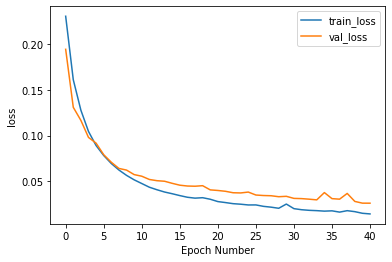

In [11]:
	trainTest.setData()


	trainTest.preprocess(paramsTrain.model_name_id) # move into if

	trainTest.setModel()

	if paramsTrain.train == True:
		trainTest.train()
	else:
    # copy pre trained model to paramsTrain.model_name_id
		trainTest.modelLoad(paramsTrain.model_name_id)

## Evaluate


In [12]:
from parameters.params_reconstruct import ParamsReconstruct
import pathlib

pathlib.Path('results/spatial_results').mkdir(parents=True, exist_ok=True)

paramsMosaic = ParamsReconstruct(paramsTrain)

paramsMosaic.mosaic_flag = True
paramsMosaic.open_set_mode = False

trainTest.evaluate(paramsMosaic)


[@debug] params_reconstruct.py:43 in __init__()
         self.overlap: 0
         self.threshold_idx: 4
[@debug] dataset.py:562 in loadMask()
         str(self.paramsTrain.path): '../../../dataset/dataset/cv_data'
[@debug] dataset.py:564 in loadMask()- self.mask.shape: (8492, 7995)
[@debug] dataset.py:386 in addPaddingToInput()
         im.shape: (12, 8492, 7995, 2)
[@debug] mosaic.py:45 in __init__()- paramsTrain.seq_date: 'jun'


[@debug] dataset = cv
[@debug] paramsTrain.model_type = UUnetConvLSTM


[@debug] mosaic.py:133 in create()- self.data.class_n: 10
[@debug] mosaic.py:134 in create()
         np.unique(self.data.full_label_test): array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8)
         len(np.unique(self.data.full_label_test)): 10
[@debug] mosaic.py:135 in create()
         np.unique(self.data.full_label_train): array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)
         len(np.unique(self.data.full_label_train)): 10


stride 32
265
249


[@debug] mosaic.py:508 in getPatchesPerBatch()- self.count_mask: 65985
[@debug] mosaic.py:510 in getPatchesPerBatch()
         self.patches_per_batch: 1245
[@debug] mosaic.py:511 in getPatchesPerBatch()
         self.patches_per_batch * self.pb.batch_processing_n: 65985
[@debug] mosaic.py:512 in getPatchesPerBatch()
         self.pb.batch_processing_n: 53


================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()- self.count_mask_overall: 0
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 0
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 0
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 1245
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 6.92
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float16')
[@debug] mosai

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 1245
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 1
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 1245
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 2490
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 6.746
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float16')

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 2490
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 2
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 2490
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 3735
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 6.625
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float16')

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 3735
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 3
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 3735
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 4980
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 6.496
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float16')

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 4980
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 4
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 4980
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 6225
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 6.36
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float16')


================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 6225
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 5
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 6225
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 7470
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 6.195
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float16')

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 7470
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 6
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 7470
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 8715
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 6.06
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float16')


================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 8715
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 7
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 8715
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 9960
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 5.863
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float16')

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 9960
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 8
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 9960
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 11205
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 5.75
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float16')

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 11205
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 9
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 11205
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 12450
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 5.617
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float1

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 12450
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 10
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 12450
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 13695
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 5.484
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 13695
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 11
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 13695
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 14940
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 5.34
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float1

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 14940
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 12
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 14940
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 16185
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 5.164
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 16185
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 13
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 16185
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 17430
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 5.035
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 17430
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 14
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 17430
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 18675
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 4.887
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 18675
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 15
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 18675
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 19920
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 4.695
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 19920
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 16
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 19920
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 21165
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 4.492
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 21165
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 17
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 21165
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 22410
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 4.414
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 22410
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 18
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 22410
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 23655
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 4.277
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 23655
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 19
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 23655
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 24900
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 4.16
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float1

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 24900
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 20
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 24900
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 26145
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 4.023
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 26145
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 21
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 26145
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 27390
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 3.865
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 27390
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 22
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 27390
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 28635
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 3.732
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 28635
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 23
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 28635
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 29880
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 3.555
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 29880
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 24
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 29880
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 31125
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 3.39
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float1

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 31125
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 25
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 31125
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 32370
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 3.244
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 32370
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 26
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 32370
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 33615
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 3.064
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 33615
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 27
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 33615
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 34860
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 2.887
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 34860
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 28
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 34860
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 36105
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 2.686
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 36105
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 29
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 36105
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 37350
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 2.475
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 37350
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 30
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 37350
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 38595
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 2.316
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 38595
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 31
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 38595
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 39840
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 2.188
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 39840
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 32
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 39840
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 41085
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 2.055
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 41085
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 33
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 41085
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 42330
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 1.928
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 42330
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 34
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 42330
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 43575
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 1.834
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 43575
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 35
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 43575
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 44820
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 1.6875
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('floa

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 44820
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 36
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 44820
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 46065
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 1.505
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 46065
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 37
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 46065
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 47310
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 1.321
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 47310
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 38
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 47310
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 48555
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 1.226
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 48555
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 39
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 48555
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 49800
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 1.134
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 49800
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 40
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 49800
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 51045
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 0.944
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 51045
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 41
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 51045
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 52290
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 0.7837
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('floa

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 52290
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 42
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 52290
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 53535
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 0.722
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 53535
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 43
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 53535
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 54780
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 0.59
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float1

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 54780
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 44
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 54780
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 56025
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 0.4912
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('floa

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 56025
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 45
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 56025
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 57270
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 0.415
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 57270
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 46
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 57270
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 58515
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 0.305
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 58515
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 47
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 58515
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 59760
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 0.1927
         np.min(patches_in): -1.432
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('floa

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 59760
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 48
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 59760
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 61005
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 0.172
         np.min(patches_in): -1.431
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('float

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 61005
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 49
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 61005
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 62250
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 0.2399
         np.min(patches_in): -1.418
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('floa

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 62250
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 50
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 62250
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 63495
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 0.1558
         np.min(patches_in): -1.419
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('floa

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 63495
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 51
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 63495
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 64740
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 0.1256
         np.min(patches_in): -1.419
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('floa

================== starting self.batch ... ==================


[@debug] mosaic.py:331 in loopOverImage()
         self.count_mask_overall: 64740
[@debug] mosaic.py:332 in loopOverImage()- self.batch: 52
[@debug] mosaic.py:333 in loopOverImage()
         self.batch * self.patches_per_batch: 64740
[@debug] mosaic.py:334 in loopOverImage()
         (self.batch + 1) * self.patches_per_batch: 65985
[@debug] mosaic.py:340 in loopOverImage()
         np.average(self.data.full_ims_test): 3.117
         np.min(self.data.full_ims_test): -1.432
         np.max(self.data.full_ims_test): 51.53
[@debug] mosaic.py:341 in loopOverImage()
         np.average(patches_in): 0.1558
         np.min(patches_in): -1.419
         np.max(patches_in): 51.53
[@debug] mosaic.py:342 in loopOverImage()
         patches_in.shape: (1245, 12, 32, 32, 2)
[@debug] mosaic.py:344 in loopOverImage()- self.count_mask_batch: 1245
[@debug] mosaic.py:345 in loopOverImage()- self.count_mask: 65985
[@debug] mosaic.py:350 in loopOverImage()
         self.pred_logits_patches.dtype: dtype('floa

Entering newLabel2labelTranslate
[@debug] np.unique(label,return_counts=True) = (array([  0,   1,   2,   3,   4,   5,   6,   7,   8, 255], dtype=uint8), array([  688991,  1191485,    36587,   141179,   207718,   100471,
         394344,      761,   131386, 65000618]))
[@debug] np.unique(label)[-1] = 255
[@debug] np.unique(label,return_counts=True) = (array([  0,   1,   2,   3,   4,   5,   6,   7,   8, 255], dtype=uint8), array([  688991,  1191485,    36587,   141179,   207718,   100471,
         394344,      761,   131386, 65000618]))
[@debug] np.unique(label,return_counts=True) = (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([65000618,   688991,  1191485,    36587,   141179,   207718,
         100471,   394344,      761,   131386]))
new_labels2labels filename <_io.BufferedReader name='results/label_translations/new_labels2labels_cv_20160613_S1.pkl'>
[@debug] new_labels2labels = {0: 0, 1: 2, 2: 3, 3: 4, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11}
[@debug] classes = [0 1 2 3 4 5 

[@debug] mosaic.py:151 in create()
         np.unique(self.prediction_mosaic, return_counts=True): (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8),
                                                                 array([65000618,   688991,  1191485,    36587,   141179,   207718,
                                                                         100471,   394344,      761,   131386]))
[@debug] mosaic.py:153 in create()- time.time()-t0: 3439.62264084816
[@debug] mosaic.py:156 in create()
         self.data.full_label_test.shape: (8492, 7995)
[@debug] mosaic.py:162 in create()
         np.unique(self.prediction_mosaic, return_counts=True): (array([ 0,  2,  3,  4,  6,  7,  8,  9, 10, 11], dtype=uint8),
                                                                 array([65000618,   688991,  1191485,    36587,   141179,   207718,
                                                                         100471,   394344,      761,   131386]))
[@debug] mosaic.py:169 in c

[@debug] important_classes_idx = [1, 2, 3, 5, 6, 7, 8, 9, 10]
[@debug] np.unique(label,return_counts=True) = (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8), array([  730790,  1199149,    25986,    88785,   312353,    83385,
         362633,      308,    89533, 65000618]))
[@debug] np.unique(predictions,return_counts=True) = (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8), array([  688991,  1191485,    36587,   141179,   207718,   100471,
         394344,      761,   131386, 65000618]))
[@debug] np.unique(self.label_mosaic,return_counts=True) = (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8), array([  730790,  1199149,    25986,    88785,   312353,    83385,
         362633,      308,    89533, 65000618]))
[@debug] np.unique(self.prediction_mosaic,return_counts=True) = (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8), array([  688991,  1191485,    36587,   141179,   207718,   100471,
        

[@debug] mosaic.py:198 in create()
         self.data.mask.shape: (8492, 7995)
         self.mask_pad.shape: (8492, 7995)
         self.label_mosaic.shape: (8492, 7995)
         self.prediction_mosaic.shape: (8492, 7995)
[@debug] mosaic.py:215 in save_prediction_label_mosaic_Nto1()
         np.unique(mask, return_counts=True): (array([0, 1, 2], dtype=uint8), array([61778564,  3222054,  2892922]))


[@debug] np.unique(self.label_mosaic,return_counts=True) = (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8), array([  730790,  1199149,    25986,    88785,   312353,    83385,
         362633,      308,    89533, 65000618]))
[@debug] np.unique(self.prediction_mosaic,return_counts=True) = (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8), array([  688991,  1191485,    36587,   141179,   207718,   100471,
         394344,      761,   131386, 65000618]))
everything outside mask is 255


[@debug] mosaic.py:226 in save_prediction_label_mosaic_Nto1()
         np.unique(self.label_mosaic,return_counts=True): (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8),
                                                           array([  730790,  1199149,    25986,    88785,   312353,    83385,
                                                                   362633,      308,    89533, 65000618]))
[@debug] mosaic.py:227 in save_prediction_label_mosaic_Nto1()
         np.unique(self.prediction_mosaic,return_counts=True): (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8),
                                                                array([  688991,  1191485,    36587,   141179,   207718,   100471,
                                                                        394344,      761,   131386, 65000618]))


(11, 3)
Gray uint8
Adding color...
RGB uint8 (8492, 7995, 3)
[@debug] custom_colormap = [[255 146  36]
 [255 255   0]
 [164 164 164]
 [255  62  62]
 [  0   0   0]
 [172  89 255]
 [  0 166  83]
 [ 40 255  40]
 [187 122  83]
 [217  64 238]
 [ 45 150 255]]
Assigning color...
RGB uint8 (8492, 7995, 3)
Saving the resulting images...
[@debug] save_folder = results/spatial_results/cv/UUnetConvLSTM/jun


[@debug] mosaic.py:290 in save_prediction_label_mosaic_Nto1()
         prediction_savename: PosixPath('results/spatial_results/cv/UUnetConvLSTM/jun/prediction_t_jun_UUnetConvLSTM_closedset_closed_set_overl0_all.png')


saving...
no file to remove
[@debug] ret = True


[@debug] mosaic.py:300 in save_prediction_label_mosaic_Nto1()
         save_folder / ("label_t_"+paramsTrain.seq_date+"_"+str(paramsTrain.model_type)+"_"+self.name_id+".png"): PosixPath('results/spatial_results/cv/UUnetConvLSTM/jun/label_t_jun_UUnetConvLSTM_closed_set.png')


[@debug] ret = True
[@debug] ret = True
======================= METRICS GET


[@debug] metrics.py:34 in get()
         prediction.shape: (8492, 7995)
         label.shape: (8492, 7995)
[@debug] metrics.py:35 in get()
         np.unique(prediction, return_counts=True): (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8),
                                                     array([  688991,  1191485,    36587,   141179,   207718,   100471,
                                                             394344,      761,   131386, 65000618]))
[@debug] metrics.py:36 in get()
         np.unique(label, return_counts=True): (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8),
                                                array([  730790,  1199149,    25986,    88785,   312353,    83385,
                                                        362633,      308,    89533, 65000618]))
[@debug] metrics.py:37 in get()
         len(np.unique(label, return_counts=True)): 2
[@debug] metrics.py:42 in get()- class_n: 9


[@debug] prediction.shape,debug,2 = (8492, 7995)
[@debug] label.shape,debug,2 = (8492, 7995)
[@debug] prediction.shape = (8492, 7995)
[@debug] prediction.shape = (67893540,)


[@debug] metrics.py:70 in get()
         np.unique(prediction, return_counts=True): (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8),
                                                     array([  688991,  1191485,    36587,   141179,   207718,   100471,
                                                             394344,      761,   131386, 65000618]))
[@debug] metrics.py:71 in get()
         np.unique(label, return_counts=True): (array([  1,   2,   3,   5,   6,   7,   8,   9,  10, 255], dtype=uint8),
                                                array([  730790,  1199149,    25986,    88785,   312353,    83385,
                                                        362633,      308,    89533, 65000618]))
[@debug] metrics.py:78 in get()
         np.unique(label,return_counts=True): (array([ 1,  2,  3,  5,  6,  7,  8,  9, 10], dtype=uint8),
                                               array([ 730790, 1199149,   25986,   88785,  312353,   83385,  362633,
     

[@debug] metrics_test = {'f1_score': 0.6260467771963101, 'f1_score_weighted': 0.7509033672062115, 'f1_score_noavg': array([0.690784  , 0.91052081, 0.48151759, 0.53425754, 0.63560937,
       0.87756723, 0.52860787, 0.39289055, 0.58266605]), 'overall_acc': 0.7486665731049783, 'confusion_matrix': array([[ 490381,   53822,   11058,   14682,    6509,    2096,  144907,
            228,    7107],
       [  63467, 1088361,    5623,    5917,    5462,    2279,   26030,
            157,    1853],
       [   2749,     417,   15065,       0,     210,       0,    7545,
              0,       0],
       [   9668,    1830,     451,   61430,    4865,     576,    7989,
              1,    1975],
       [  15473,    1660,    3460,   53063,  165281,   12338,    7361,
             86,   53631],
       [     30,      98,       5,     127,    1569,   80673,     280,
              0,     603],
       [ 107077,   44587,     922,    3548,    4264,     244,  200072,
             63,    1856],
       [      3,   